### Binary Classification of Machine Failures

Playground Series - Season 3, Episode 17

https://www.kaggle.com/competitions/playground-series-s3e17/overview


- 라이브러리 정의

In [ ]:
!pip install hyperopt
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import plot_importance

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

#### 데이터 탐색

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90954 entries, 0 to 90953
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       90954 non-null  int64  
 1   Product ID               90954 non-null  object 
 2   Type                     90954 non-null  object 
 3   Air temperature [K]      90954 non-null  float64
 4   Process temperature [K]  90954 non-null  float64
 5   Rotational speed [rpm]   90954 non-null  int64  
 6   Torque [Nm]              90954 non-null  float64
 7   Tool wear [min]          90954 non-null  int64  
 8   TWF                      90954 non-null  int64  
 9   HDF                      90954 non-null  int64  
 10  PWF                      90954 non-null  int64  
 11  OSF                      90954 non-null  int64  
 12  RNF                      90954 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 9.0+ MB


In [ ]:
train.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [ ]:
test.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

- 연속형 피처는 높은 순으로 정렬하고 유일값이 2개인 피처들은 개수 확인

In [ ]:
train['Type'].value_counts()

L    95354
M    32152
H     8923
Name: Type, dtype: int64

In [ ]:
train['Air temperature [K]'].sort_values(ascending=False)

92325     304.4
134117    304.4
83984     304.4
26064     304.4
52490     304.4
          ...  
77554     295.4
79092     295.3
42381     295.3
119576    295.3
31605     295.3
Name: Air temperature [K], Length: 136429, dtype: float64

In [ ]:
display(train['Process temperature [K]'].sort_values(ascending=False),
        train['Rotational speed [rpm]'].sort_values(ascending=False),
        train['Torque [Nm]'].sort_values(ascending=False),
        train['Tool wear [min]'].sort_values(ascending=False))

37148     313.8
55171     313.8
17555     313.8
126863    313.8
86667     313.8
          ...  
119576    305.8
44537     305.8
77554     305.8
128155    305.8
135263    305.8
Name: Process temperature [K], Length: 136429, dtype: float64

115121    2886
24555     2886
74415     2874
27997     2874
116370    2874
          ... 
109846    1183
120597    1183
10802     1183
17915     1183
23070     1181
Name: Rotational speed [rpm], Length: 136429, dtype: int64

20092     76.6
34276     76.6
113285    76.6
10889     76.6
28338     76.4
          ... 
102438     4.2
96815      4.2
112786     4.2
3856       4.0
118673     3.8
Name: Torque [Nm], Length: 136429, dtype: float64

24853     253
104666    253
33104     253
27603     251
117946    246
         ... 
59144       0
35376       0
93418       0
93426       0
85093       0
Name: Tool wear [min], Length: 136429, dtype: int64

HDF - heat dissipation failure

RNF - random failure

OSF - overstrain failure

TWF - tool wear failure

PWF - power failure

In [ ]:
display(train['TWF'].value_counts(),
        train['HDF'].value_counts(),
        train['PWF'].value_counts(),
        train['OSF'].value_counts(),
        train['RNF'].value_counts())

0    136217
1       212
Name: TWF, dtype: int64

0    135725
1       704
Name: HDF, dtype: int64

0    136102
1       327
Name: PWF, dtype: int64

0    135889
1       540
Name: OSF, dtype: int64

0    136121
1       308
Name: RNF, dtype: int64

5개 피처 모두 0인 경우가 훨씬 많음

- 상관관계 확인

<Axes: >

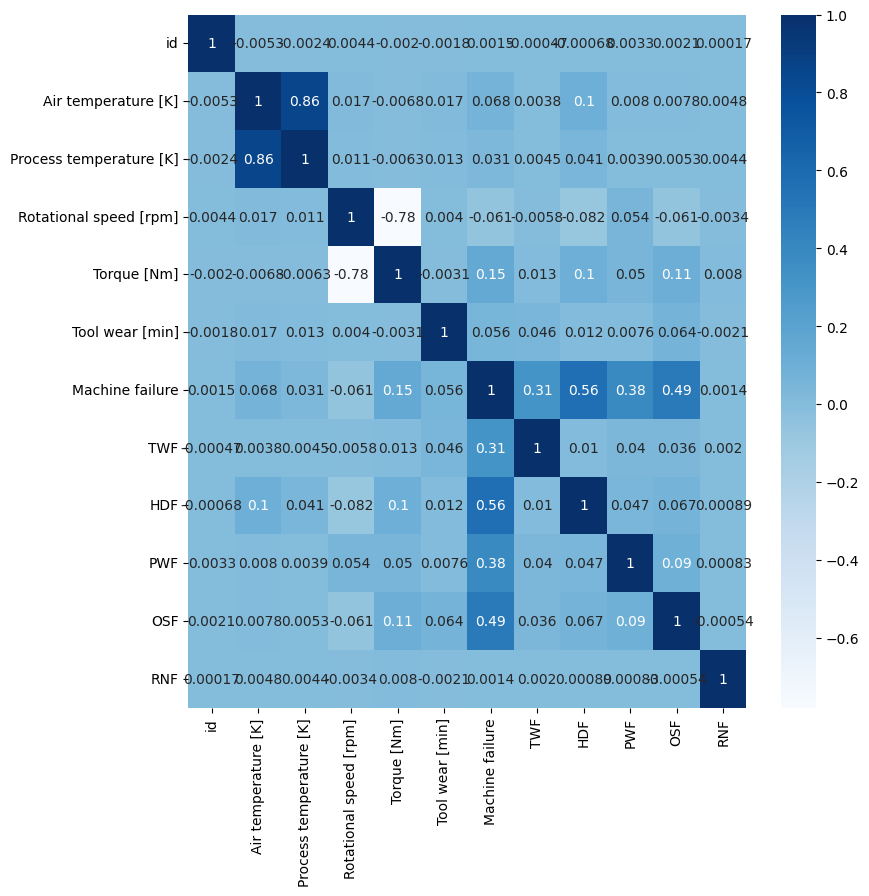

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(data=train.corr(), annot=True, cmap='Blues')

Machine Failure와 높은 상관성을 가지는 피처 없음 >> 이상치를 제거할만한 피처가 없음



In [ ]:
train['Machine failure'].value_counts()

0    134281
1      2148
Name: Machine failure, dtype: int64

<Axes: >

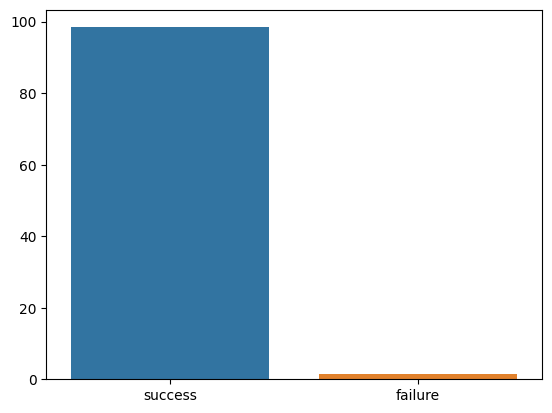

In [ ]:
mac_0 = train[train['Machine failure'] == 0]
mac_1 = train[train['Machine failure'] == 1]

total = len(train)
percent_0 = len(mac_0) / total * 100
percent_1 = len(mac_1) / total * 100

labels= ['success', 'failure']
percentage = [percent_0, percent_1]
sns.barplot(x=labels, y=percentage)

타겟값의 분포가 불균형함

#### 전처리

- 칼럼명 깔끔하게 바꾸기

In [ ]:
train.rename(columns={'Air temperature [K]' : 'Air_temperature',
                   'Process temperature [K]' : 'Process_temperature',
                    'Rotational speed [rpm]' : 'Rotational_speed',
                        'Torque [Nm]' : 'Torque',
                        'Tool wear [min]' : 'Tool_wear'}, inplace=True)

test.rename(columns={'Air temperature [K]' : 'Air_temperature',
                   'Process temperature [K]' : 'Process_temperature',
                    'Rotational speed [rpm]' : 'Rotational_speed',
                        'Torque [Nm]' : 'Torque',
                        'Tool wear [min]' : 'Tool_wear'}, inplace=True)

In [ ]:
display(train.columns, test.columns)

Index(['id', 'Product ID', 'Type', 'Air_temperature', 'Process_temperature',
       'Rotational_speed', 'Torque', 'Tool_wear', 'Machine failure', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

Index(['id', 'Product ID', 'Type', 'Air_temperature', 'Process_temperature',
       'Rotational_speed', 'Torque', 'Tool_wear', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

- Type 피처 one-hot encoding 진행 **>> 범죄 유형 분류에서 '요일'과 '범죄발생지'를 인코딩 후 새로운 칼럼으로 생성한게 생각나서 적용해봄**

In [ ]:
train = pd.concat([train, pd.get_dummies(train['Type'])], axis=1)
print(train.shape)
train.head(3)

(136429, 17)


,id,Product ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine failure,TWF,HDF,PWF,OSF,RNF,H,L,M
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,0,1,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0,0,1
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,0,1,0


In [ ]:
train = train.drop('Type', axis=1)

In [ ]:
test = pd.concat([test, pd.get_dummies(test['Type'])], axis=1)
print(test.shape)
test.head(3)

(90954, 16)


,id,Product ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,H,L,M
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0,0,1,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0,0,1,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0,0,1,0


In [ ]:
test = test.drop('Type', axis=1)

In [ ]:
display(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   136429 non-null  int64  
 1   Product ID           136429 non-null  object 
 2   Air_temperature      136429 non-null  float64
 3   Process_temperature  136429 non-null  float64
 4   Rotational_speed     136429 non-null  int64  
 5   Torque               136429 non-null  float64
 6   Tool_wear            136429 non-null  int64  
 7   Machine failure      136429 non-null  int64  
 8   TWF                  136429 non-null  int64  
 9   HDF                  136429 non-null  int64  
 10  PWF                  136429 non-null  int64  
 11  OSF                  136429 non-null  int64  
 12  RNF                  136429 non-null  int64  
 13  H                    136429 non-null  uint8  
 14  L                    136429 non-null  uint8  
 15  M                

None

None

- 데이터 나누기

In [ ]:
X = train.drop(['id', 'Product ID', 'Machine failure'], axis=1)
y = train['Machine failure']
test = test.drop(['id', 'Product ID'], axis=1)

- 타겟값 오버샘플링 진행, SMOTE

In [ ]:
smote = SMOTE(random_state=0)
X_over, y_over = smote.fit_resample(X, y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터셋:', X.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터셋:', X_over.shape, y_over.shape)
print('SMOTE 적용 후 레이블값 분포: \n', pd.Series(y_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터셋: (136429, 13) (136429,)
SMOTE 적용 후 학습용 피처/레이블 데이터셋: (268562, 13) (268562,)
SMOTE 적용 후 레이블값 분포: 
 0    134281
1    134281
Name: Machine failure, dtype: int64


학습용 데이터가 증식됐고 SMOTE 적용 후 레이블값 분포도 동일해짐

#### 모델 선정, 하이퍼 파라미터 튜닝

- 여러 모델로 학습시켜보고 여러 평가 지표로 평가할 수 있는 함수 생성, 가장 뛰어난 모델 뽑아내기

- 이 부분은 https://www.kaggle.com/code/natalialimanska/machine-failure-eda-and-classification#3.-Baseline-Modeling 일부 참고


In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_over, y_over, test_size=0.2, random_state=0)

In [ ]:
#여러 모델을 정의한 리스트 생성
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree Classifier', DecisionTreeClassifier()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('XGBoost Classifier', XGBClassifier()),
    ('LGBMClassifier', LGBMClassifier()),
    ('CatBoostClassifier', CatBoostClassifier())
    ]

#각 모델의 결과를 저장하는 리스트 생성
results = []

for name, model in models:

    model.fit(X_tr, y_tr)

    y_train_pred = model.predict(X_val)
    y_test_pred = model.predict(X_val)

    #여러 지표로 성능 평가하기
    auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    tr_train_score = accuracy_score(y_val, y_train_pred)
    tr_test_score = accuracy_score(y_val, y_test_pred)
    f1 = f1_score(y_val, y_test_pred, average='weighted')
    recall = recall_score(y_val, y_test_pred, average='weighted')
    precision = precision_score(y_val, y_test_pred, average='weighted')

    #results 리스트에 결과 추가하기
    results.append({
        'Model': name,
        'AUC': auc_score,
        'Accuracy Test': tr_test_score,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
    })

print(results)

Learning rate set to 0.102036
0:	learn: 0.6109350	total: 96.8ms	remaining: 1m 36s
1:	learn: 0.5355529	total: 145ms	remaining: 1m 12s
2:	learn: 0.4901689	total: 194ms	remaining: 1m 4s
3:	learn: 0.4507248	total: 238ms	remaining: 59.2s
4:	learn: 0.4211113	total: 281ms	remaining: 55.9s
5:	learn: 0.3662502	total: 324ms	remaining: 53.7s
6:	learn: 0.3365801	total: 368ms	remaining: 52.2s
7:	learn: 0.3189286	total: 416ms	remaining: 51.6s
8:	learn: 0.3075743	total: 460ms	remaining: 50.6s
9:	learn: 0.2995168	total: 512ms	remaining: 50.7s
10:	learn: 0.2926250	total: 559ms	remaining: 50.3s
11:	learn: 0.2853430	total: 612ms	remaining: 50.4s
12:	learn: 0.2779039	total: 662ms	remaining: 50.2s
13:	learn: 0.2730323	total: 707ms	remaining: 49.8s
14:	learn: 0.2685427	total: 762ms	remaining: 50s
15:	learn: 0.2643568	total: 812ms	remaining: 50s
16:	learn: 0.2545408	total: 868ms	remaining: 50.2s
17:	learn: 0.2505880	total: 914ms	remaining: 49.9s
18:	learn: 0.2478953	total: 965ms	remaining: 49.8s
19:	learn: 0

In [ ]:
df_metrics = pd.DataFrame(results)
df_metrics

,Model,AUC,Accuracy Test,Precision,Recall,F1
0,Logistic Regression,0.942765,0.883846,0.887709,0.883846,0.883577
1,Decision Tree Classifier,0.976873,0.976765,0.976823,0.976765,0.976764
2,Random Forest Classifier,0.999265,0.988271,0.988277,0.988271,0.988271
3,GradientBoostingClassifier,0.976738,0.925065,0.925516,0.925065,0.925049
4,AdaBoostClassifier,0.968149,0.910096,0.910953,0.910096,0.910057
5,XGBoost Classifier,0.999296,0.993540,0.993548,0.993540,0.993540
6,LGBMClassifier,0.997281,0.973712,0.973843,0.973712,0.973711
7,CatBoostClassifier,0.999367,0.993875,0.993893,0.993875,0.993875


8개의 모델 중 로지스틱회귀는 최종 메타 모델로 이용

나머지 7개를 개별 모델로 선정한 뒤 스태킹

In [ ]:
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
xgb_clf = XGBClassifier(n_estimators=100, random_state=0)
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=0)
cat_clf = CatBoostClassifier(n_estimators=100, random_state=0)

lr_final = LogisticRegression()

dt_clf.fit(X, y)
rf_clf.fit(X, y)
gb_clf.fit(X, y)
ada_clf.fit(X, y)
xgb_clf.fit(X, y)
lgbm_clf.fit(X, y)
cat_clf.fit(X, y)

dt_pred = dt_clf.predict(test)
rf_pred = rf_clf.predict(test)
gb_pred = gb_clf.predict(test)
ada_pred = ada_clf.predict(test)
xgb_pred = xgb_clf.predict(test)
lgbm_pred = lgbm_clf.predict(test)
cat_pred = cat_clf.predict(test)

Learning rate set to 0.5
0:	learn: 0.3239851	total: 17.2ms	remaining: 1.7s
1:	learn: 0.1809791	total: 31.9ms	remaining: 1.56s
2:	learn: 0.1098628	total: 56ms	remaining: 1.81s
3:	learn: 0.0713061	total: 71.4ms	remaining: 1.71s
4:	learn: 0.0497096	total: 86.3ms	remaining: 1.64s
5:	learn: 0.0374989	total: 101ms	remaining: 1.58s
6:	learn: 0.0303579	total: 115ms	remaining: 1.53s
7:	learn: 0.0261617	total: 130ms	remaining: 1.49s
8:	learn: 0.0240369	total: 155ms	remaining: 1.56s
9:	learn: 0.0226853	total: 170ms	remaining: 1.53s
10:	learn: 0.0219744	total: 192ms	remaining: 1.55s
11:	learn: 0.0216856	total: 211ms	remaining: 1.54s
12:	learn: 0.0213762	total: 226ms	remaining: 1.51s
13:	learn: 0.0212215	total: 242ms	remaining: 1.48s
14:	learn: 0.0211233	total: 258ms	remaining: 1.46s
15:	learn: 0.0210235	total: 273ms	remaining: 1.43s
16:	learn: 0.0209517	total: 289ms	remaining: 1.41s
17:	learn: 0.0208456	total: 305ms	remaining: 1.39s
18:	learn: 0.0207697	total: 319ms	remaining: 1.36s
19:	learn: 0.0

In [ ]:
pred = []

# 모델별 예측 결과를 pred 배열에 추가
pred.append(dt_clf.predict(X))
pred.append(rf_clf.predict(X))
pred.append(gb_clf.predict(X))
pred.append(ada_clf.predict(X))
pred.append(xgb_clf.predict(X))
pred.append(lgbm_clf.predict(X))
pred.append(cat_clf.predict(X))

# pred 배열을 전치하여 예측 결과 형태 조정
pred = np.transpose(pred)

# 최종 메타 모델 학습
lr_final.fit(pred, y)

test_pred = []
test_pred.append(dt_clf.predict(test))
test_pred.append(rf_clf.predict(test))
test_pred.append(gb_clf.predict(test))
test_pred.append(ada_clf.predict(test))
test_pred.append(xgb_clf.predict(test))
test_pred.append(lgbm_clf.predict(test))
test_pred.append(cat_clf.predict(test))

# 테스트 데이터 예측 결과 배열을 전치하여 형태 조정
test_pred = np.transpose(test_pred)

# 테스트 데이터에 대한 예측
final_test = lr_final.predict(test_pred)

In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv')
sample_submission['Machine failure'] = final_test
sample_submission

,id,Machine failure
0,136429,0
1,136430,0
2,136431,0
3,136432,0
4,136433,0
...,...,...
90949,227378,0
90950,227379,0
90951,227380,0
90952,227381,0


In [ ]:
sample_submission.to_csv("./machine_submit_2.csv", index = False)

#### 첫번째 제출 Score:0.91433

#### 두번째 제출 Score: 0.91906
